create random small dataset from test data

In [13]:
random_sample = 20
test_data_all_file = f'C:/Users/97254/VScode/data/compare'
mpd.create_random_mixed_data(test_data_all_file, random_sample, filtered=True)

Data successfully written to C:/Users/97254/VScode/data/compare/random/random_10_filtered.csv


create vectorestore

In [ ]:
mrag.save_vectorstore_faiss(embedding, embedding_name)

In [ ]:
import my_process_data as mpd
import create_messages as cm
import my_rag as mrag
import os
from tqdm import tqdm
import warnings
import pandas as pd
import warnings
from langchain_community.embeddings import OllamaEmbeddings, HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.runnables import RunnablePassthrough
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, FewShotPromptTemplate
import ftfy




In [ ]:
# Set environment variables for API keys

os.environ["GROQ_API_KEY"] = ""
os.environ["HF_TOKEN"] = ""


In [3]:
# Initialize embeddings
#embedding_name = "sentence-transformers/all-MiniLM-L6-v2" # SBERT 
embedding_name = "sentence-transformers/all-roberta-large-v1" # Description: Based on RoBERTa-large, this model has been fine-tuned for various semantic similarity tasks. 
embedding = HuggingFaceEmbeddings(model_name=embedding_name) 

#model_name = "llama-3.1-70b-versatile"
#model_name = "llama-3.1-8b-instant"
model_name = "llama3-70b-8192"

# Initialize LLM
llm = ChatGroq(model=model_name, temperature=0.6 , model_kwargs={
    "top_p" : 0.7,
    "seed" : 109,
    "response_format" : {"type": "json_object"},
    })

c:\Users\97254\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\97254\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\97254\AppData\Local\Programs\Python\Python310\lib\site-packages\bitsandbytes\cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-

function 'cadam32bit_grad_fp32' not found


c:\Users\97254\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


check different score_threshold

In [ ]:
data_name = 'random_5.csv'
file_path = f'./data/compare/random/{data_name}'

scores = [0.0, 0.3, 0.4, 0.5, 1.0]
for score_threshold in scores:
    label_name = f"rag_in_domain_{score_threshold}"
    mrag.ask_llm_from_csv_similarity_score_threshold(file_path, embedding, llm, label_name, embedding_name, score_threshold=score_threshold)

Results for rag_cross_domain_0.2 prompt:
+------------------------------+---------------+----------------+----------------+-----------------+-----------------+-----------+--------+----------+----------+
|           dataset            | total_samples | true_positives | true_negatives | false_positives | false_negatives | precision | recall | f1_score | accuracy |
+------------------------------+---------------+----------------+----------------+-----------------+-----------------+-----------+--------+----------+----------+
|             MSTI             |      10       |       5        |       0        |        5        |        0        |    0.5    |  1.0   |  0.667   |   0.5    |
|           MUStARD            |      10       |       5        |       2        |        3        |        0        |   0.625   |  1.0   |  0.769   |   0.7    |
|            Ptacek            |      10       |       5        |       3        |        2        |        0        |   0.714   |  1.0   |  0.833   

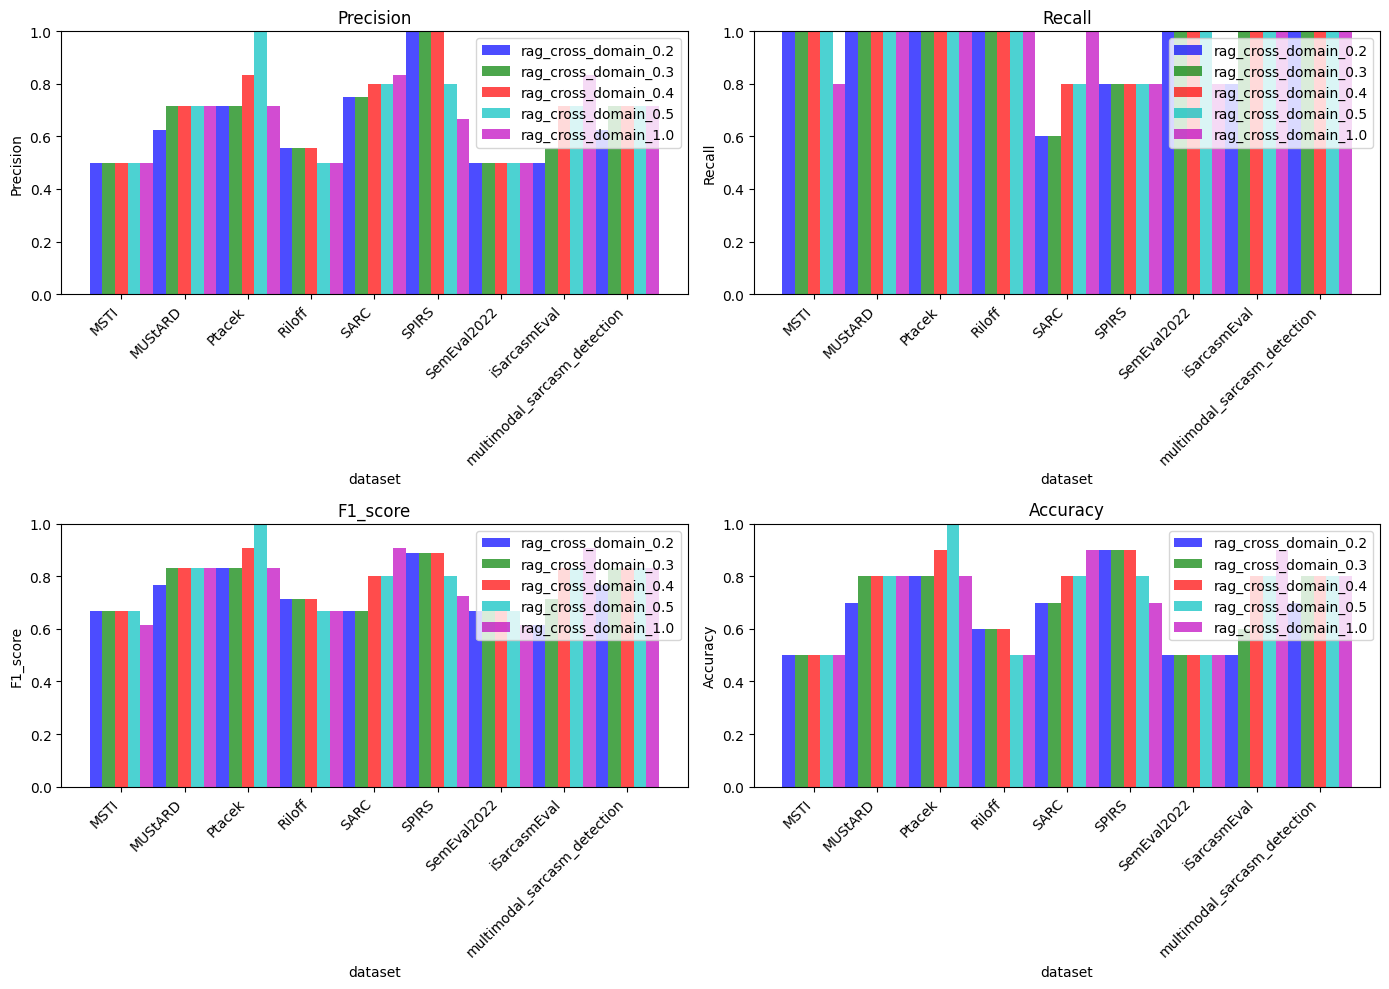

In [271]:
data_name = 'random_5.csv'
file_path = f'./data/compare/random/{data_name}'
scores = [0.0, 0.3, 0.4, 0.5, 1.0]
column_names = [f"rag_cross_domain_{score_threshold}" for score_threshold in scores]
mpd.show_results_from_csv(column_names, file_path)

analysis the results and find answers: (all data at csv file `random_5.csv`)

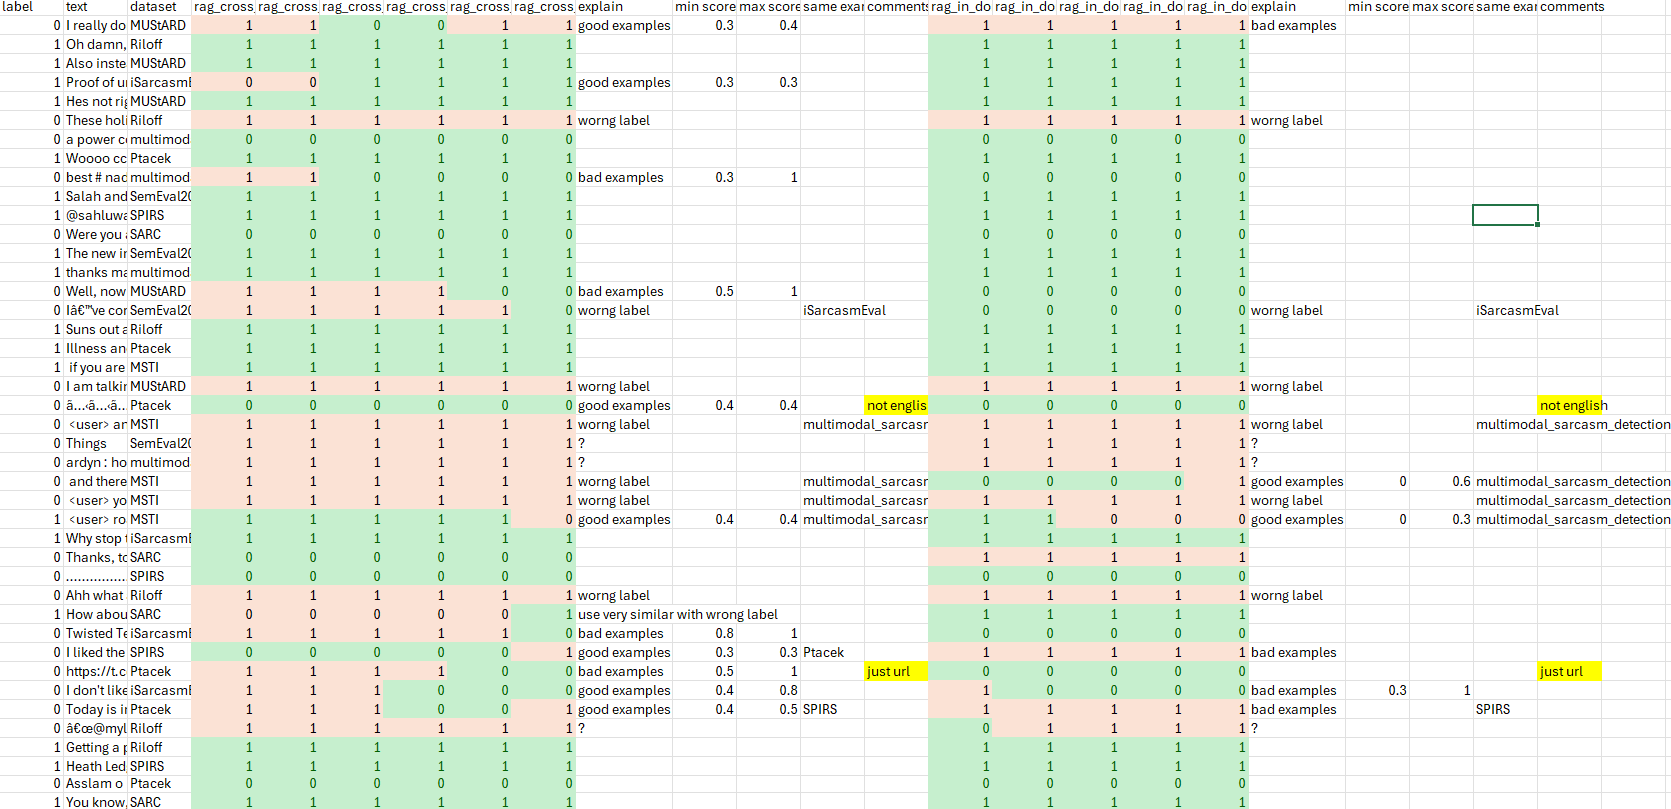

In [6]:
for dataset in mpd.datasets:
    file_path = f'./data/{dataset}/data.csv'
    r = mpd.count_samples_labels(file_path)
    print(r)

[{'dataset': 'multimodal_sarcasm_detection', 'total_samples': 33859, 'label_0': 17598, 'label_1': 16261}]
[{'dataset': 'MUStARD', 'total_samples': 690, 'label_0': 345, 'label_1': 345}]
[{'dataset': 'iSarcasmEval', 'total_samples': 6668, 'label_0': 5221, 'label_1': 1447}]
[{'dataset': 'SPIRS', 'total_samples': 30317, 'label_0': 15202, 'label_1': 15115}]
[{'dataset': 'SARC', 'total_samples': 9900, 'label_0': 4950, 'label_1': 4950}]
[{'dataset': 'SemEval2022', 'total_samples': 2133, 'label_0': 1066, 'label_1': 1067}]
[{'dataset': 'Ptacek', 'total_samples': 68124, 'label_0': 36000, 'label_1': 32124}]
[{'dataset': 'Riloff', 'total_samples': 1771, 'label_0': 1413, 'label_1': 358}]


i found out that the data is not clean:
- there is a lot of same text between different datasets and even inside same dataset between train and test with different labels!!

- there are some wrong labels, mostly at (`MSTI`, `SemEval2022`, `Riloff` )
- the effective score_threshold is mostly between `0.3 - 0.5` above is like `Zero-Shot` and less is like `random Few-Shot`
so i now will clean the datasets only from duplicate data between train and test, and between different datasets

Here is the table with TEST DATA = `dataset`, `total_samples`, `label 0` and `label 1`:

|           dataset            | total_samples | label 0           | label 1           |
|------------------------------|---------------|-------------------|-------------------|
| MSTI                         |      689      |        365        |        324        |
| MUStARD                      |      136      |        80         |        56         |
| Ptacek                       |     12850     |       6427        |       6423        |
| Riloff                       |      144      |        66         |        78         |
| SARC                         |      450      |       225         |       225         |
| SPIRS                        |     5992      |       2998        |       2994        |
| SemEval2022                  |      400      |        200        |        200        |
| iSarcasmEval                 |      390      |        93         |        297        |
| multimodal_sarcasm_detection |     6470      |       3284        |       3186        |

Here is the table with TRAIN DATA = `dataset`, `total_samples`, `label 0` and `label 1`:


|           dataset            | total_samples | label 0           | label 1           |
|------------------------------|---------------|-------------------|-------------------|
| MSTI                         |      2755     |        1357       |        1398       |
| MUStARD                      |       540     |         258       |         282       |
| Ptacek                       |     51398     |       25697       |       25701       |
| Riloff                       |       572     |         292       |         280       |
| SARC                         |      4500     |        2250       |        2250       |
| SPIRS                        |     23964     |       11971       |       11993       |
| SemEval2022                  |      1733     |         866       |         867       |
| iSarcasmEval                 |      1680     |         377       |        1303       |
| multimodal_sarcasm_detection |     25878     |       12890       |       12988       |



now i filtered the train_data and test_data

In [ ]:
#split to train and test
for dataset in mpd.datasets:
    file_path = f'./data/{dataset}/'
    split_data(file_path)

In [7]:
input_path = './data/'
mpd.filter_duplicates_and_non_english_save_train_data(input_path)


Remove from multimodal_sarcasm_detection:
8 duplicates with other datasets' train data (3 with different labels)
245 duplicates with test data (2 with different labels)
4 duplicates with other datasets' test data (1 with different labels)
0 texts with no English at all

Remove from MUStARD:
5 duplicates with other datasets' train data (1 with different labels)
3 duplicates with test data (1 with different labels)
4 duplicates with other datasets' test data (1 with different labels)
0 texts with no English at all

Remove from iSarcasmEval:
860 duplicates with other datasets' train data (8 with different labels)
470 duplicates with test data (8 with different labels)
220 duplicates with other datasets' test data (2 with different labels)
2 texts with no English at all

Remove from SPIRS:
2057 duplicates with other datasets' train data (10 with different labels)
3 duplicates with test data (1 with different labels)
531 duplicates with other datasets' test data (6 with different labels)
9

In [8]:
input_path = './data/'
mpd.filter_non_english_and_save_test_data(input_path)


Remove from multimodal_sarcasm_detection test data:
0 texts with no English at all

Remove from MUStARD test data:
0 texts with no English at all

Remove from iSarcasmEval test data:
2 texts with no English at all

Remove from SPIRS test data:
60 texts with no English at all

Remove from SARC test data:
5 texts with no English at all

Remove from SemEval2022 test data:
0 texts with no English at all

Remove from Ptacek test data:
245 texts with no English at all

Remove from Riloff test data:
0 texts with no English at all


now we will save also `train_data_filtered_all` and `test_data_filtered_all`

In [ ]:
input_path = './data/'
mpd.merge_csv('train_data_filtered', input_path)
mpd.merge_csv('test_data_filtered', input_path)

now we will save vectorstore for filtered data

In [ ]:
mrag.save_vectorstore_faiss(embedding, embedding_name, filtered=True)

In [10]:
# create new random file from filtered data for research and testing
random_sample = 20
test_data_all_file = f'C:/Users/97254/VScode/data'
mpd.create_random_mixed_data(test_data_all_file, random_sample, filtered=True)

Data successfully written to C:/Users/97254/VScode/data/random/random_10_filtered.csv


i check the different embeddings models and score_threshold at embedding.ipynb

The results for roberta embedding model with score_threshold 0.0:

Results for zero_shot prompt:
+------------------------------+---------------+----------------+----------------+-----------------+-----------------+-----------+--------+----------+----------+
|           dataset            | total_samples | true_positives | true_negatives | false_positives | false_negatives | precision | recall | f1_score | accuracy |
+------------------------------+---------------+----------------+----------------+-----------------+-----------------+-----------+--------+----------+----------+
|           MUStARD            |      138      |       72       |       20       |       33        |       13        |   0.686   | 0.847  |  0.758   |  0.667   |
|            Ptacek            |     13380     |      6331      |      4543      |      2471       |       35        |   0.719   | 0.995  |  0.835   |  0.813   |
|            Riloff            |      355      |       68       |      116       |       171       |        0        |   0.285   |  1.0   |  0.443   |  0.518   

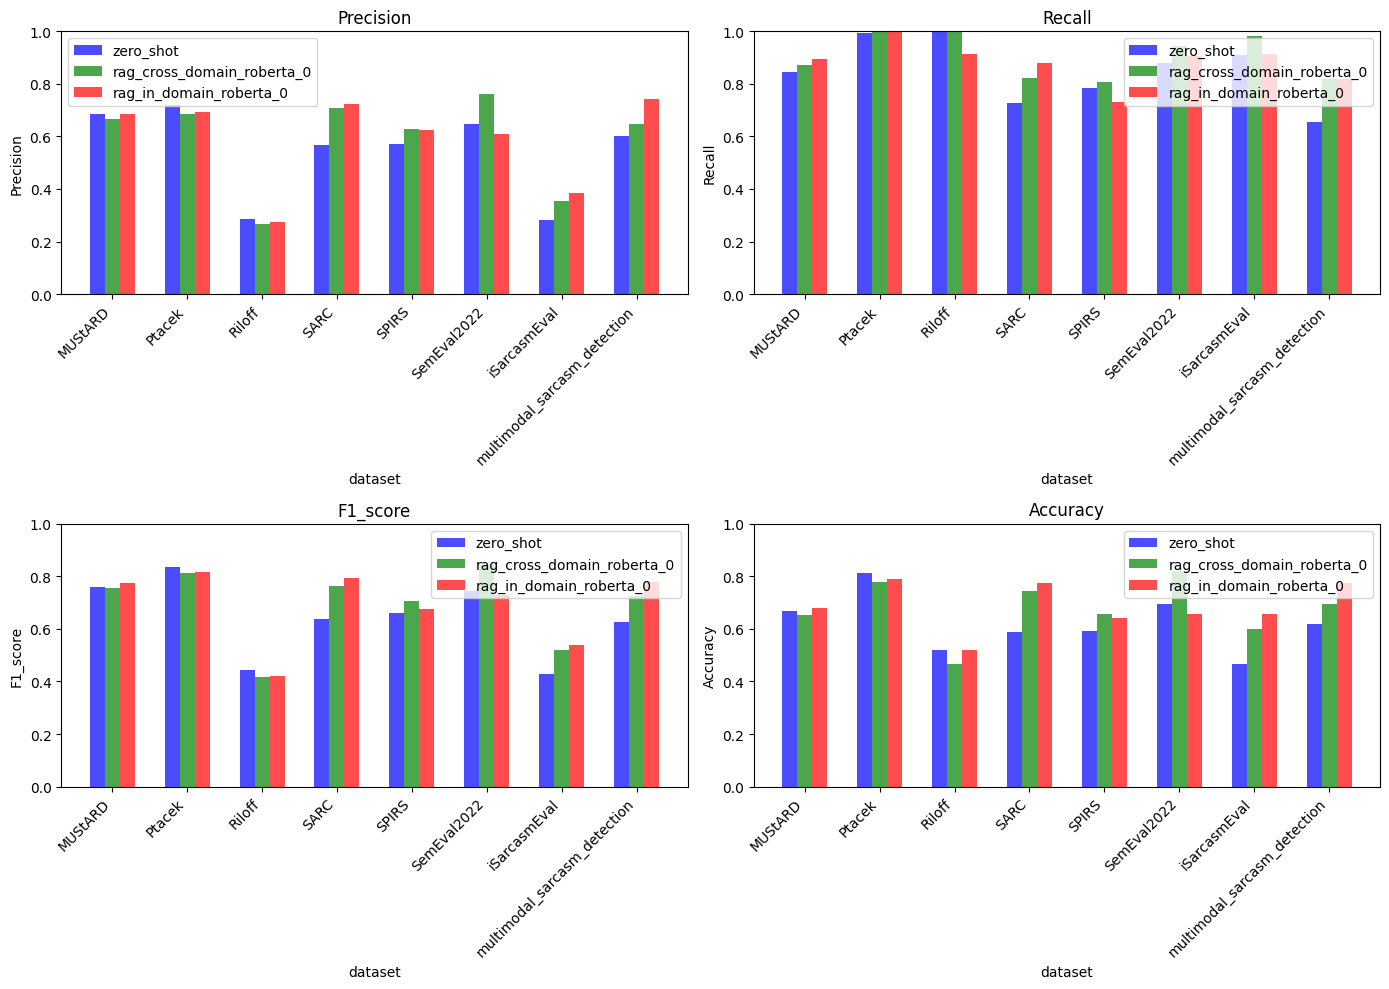

In [4]:
import my_process_data as mpd
file_path = f'./data/all/test_data_filtered_all.csv'
column_names = ["zero_shot", "rag_cross_domain_roberta_0", "rag_in_domain_roberta_0"]

mpd.show_results_from_csv(column_names, file_path)

In [ ]:
# Here i checked the results for sentence with the explain of the llm and prompt
dataset = "all"
index_path = f"./faiss/{embedding_name}/{dataset}"
retriever = mrag.get_retriever_similarity_score_threshold(index_path, embedding, score_threshold=1.0)
sentence = """
Football is a rollercoaster. And all those losses and heartbreaks are all worth it for nights like this. #AVFC #AVLARS
"""
mrag.ask_llm_with_rag(retriever, llm, sentence, print_prompt=True)

add to the csv the context for each RAG - IN\ALL

In [4]:
#context ID
label_name = f"context_in"
index_path = "./faiss/data/sentence-transformers/all-roberta-large-v1/all"
retriever = mrag.get_retriever_similarity_score_threshold(index_path, embedding, k=50)

files = ["./data/all/data_all_rag_in.csv"]
for file_path in files:
  try:
    mrag.add_context_for_csv_rag(file_path, embedding, embedding_name, label_name, retriever, all=False)
  except Exception as e:
    print(f"An error occurred during processing: {e}")


Processing ./data/all/data_all_rag_in.csv: 100%|██████████| 153462/153462 [21:33:11<00:00,  1.98it/s]        


In [ ]:
#context ALL
label_name = f"context_all"
index_path = "./faiss/data/sentence-transformers/all-roberta-large-v1/all"
retriever = mrag.get_retriever_similarity_score_threshold(index_path, embedding)

files = ["./data/all/data_all_rag_all.csv"]
for file_path in files:
  try:
    mrag.add_context_for_csv_rag(file_path, embedding, embedding_name, label_name, retriever, all=True)
  except Exception as e:
    print(f"An error occurred during processing: {e}")


In [4]:
#context ALL------------------------------------------------------------------------------------------
label_name = f"context_all"
index_path = "./faiss/data/sentence-transformers/all-roberta-large-v1/all"
retriever = mrag.get_retriever_similarity_score_threshold(index_path, embedding)

files = ["./data/all/data.csv"]
for file_path in files:
  try:
    mrag.add_context_for_csv_rag(file_path, embedding, embedding_name, label_name, retriever, all=True)
  except Exception as e:
    print(f"An error occurred during processing: {e}")


Processing ./data/all/data.csv: 100%|██████████| 2133/2133 [15:37<00:00,  2.28it/s]


F1 score

In [23]:
import pandas as pd
from sklearn.metrics import f1_score

def get_f1_scores_with_datasets(column_names, file_path):
    # Load the dataset
    data = pd.read_csv(file_path, encoding='latin1')
    
    for column_name in column_names:
        print(f"F1 Scores for {column_name} prompt:")
        
        # Extract the relevant columns
        results = data[['dataset', 'label', column_name]]

        # Grouping the data by dataset and analyzing the results
        grouped = results.groupby('dataset')

        # Initialize lists to store F1 scores across all datasets
        all_macro_f1_1 = []
        all_weighted_f1_1 = []
        all_f1_class_1 = []
        
        all_macro_f1_0 = []
        all_weighted_f1_0 = []
        all_f1_class_0 = []

        all_custom_f1_pos = []
        all_custom_f1_neg = []

        for dataset_name, group in grouped:
            y_true = group['label']
            y_pred = group[column_name]

            # Calculate true positives, true negatives, false positives, and false negatives
            tp = ((y_pred == 1) & (y_true == 1)).sum()
            tn = ((y_pred == 0) & (y_true == 0)).sum()
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()

            # Custom F1 calculations
            f1_pos = 2 * tp / ((2 * tp) + fp + fn) if (2 * tp + fp + fn) > 0 else 0
            f1_neg = 2 * tn / ((2 * tn) + fn + fp) if (2 * tn + fn + fp) > 0 else 0

            # Calculate standard F1 scores using sklearn
            macro_f1 = f1_score(y_true, y_pred, average='macro')
            weighted_f1 = f1_score(y_true, y_pred, average='weighted')
            f1_class_1 = f1_score(y_true, y_pred, average='binary', pos_label=1)
            f1_class_0 = f1_score(y_true, y_pred, average='binary', pos_label=0)

            # Store the results
            all_macro_f1_1.append(macro_f1)
            all_weighted_f1_1.append(weighted_f1)
            all_f1_class_1.append(f1_class_1)
            all_f1_class_0.append(f1_class_0)

            all_custom_f1_pos.append(f1_pos)
            all_custom_f1_neg.append(f1_neg)

            # Print all F1 scores for the current dataset in one row
            print(f"Dataset: {dataset_name} | F1 Class 0 (f1_neg): {f1_neg:.2f} and {f1_class_0:.2f} | F1 Class 1 (f1_pos): {f1_pos:.2f} and {f1_class_1:.2f} | Macro F1: {macro_f1:.2f} | Weighted F1: {weighted_f1:.2f}")
            print("-----------------------------")
        
        # Calculate the average F1 scores across all datasets
        avg_macro_f1_1 = sum(all_macro_f1_1) / len(all_macro_f1_1)
        avg_weighted_f1_1 = sum(all_weighted_f1_1) / len(all_weighted_f1_1)
        avg_f1_class_1 = sum(all_f1_class_1) / len(all_f1_class_1)
        avg_f1_class_0 = sum(all_f1_class_0) / len(all_f1_class_0)

        avg_custom_f1_pos = sum(all_custom_f1_pos) / len(all_custom_f1_pos)
        avg_custom_f1_neg = sum(all_custom_f1_neg) / len(all_custom_f1_neg)
        
        # Print the average F1 scores
        print("\nAverage F1 Scores across all datasets:")
        print(f"  Average F1 Score for class 1 (f1_pos): {avg_f1_class_1:.2f}")
        print(f"  Average F1 Score for class 0 (f1_neg): {avg_f1_class_0:.2f}")
        print(f"  Average F1 Score (macro): {avg_macro_f1_1:.2f}")
        print(f"  Average F1 Score (weighted): {avg_weighted_f1_1:.2f}")
        print(f"  Custom Average F1 Score (f1_pos): {avg_custom_f1_pos:.2f}")
        print(f"  Custom Average F1 Score (f1_neg): {avg_custom_f1_neg:.2f}")
        print("\n+++++++++++++++++++++\n")


In [2]:
def replace_invalid_labels(file_path, label_name, output_file_path):
    """
    Replace invalid values in the specified column with NaN and save the cleaned DataFrame.

    :param file_path: str, path to the CSV file.
    :param label_name: str, the name of the column to check.
    :param output_file_path: str, path to save the cleaned CSV file.
    """
    try:
        # Attempt to specify dtype for the column to avoid mixed types
        df = pd.read_csv(file_path, encoding='latin1', dtype={label_name: 'object'}, low_memory=False)
    except ValueError as e:
        print(f"Error reading the file with specified dtype: {e}")
        return
    
    # Convert the column to numeric, coercing errors to NaN
    df[label_name] = pd.to_numeric(df[label_name], errors='coerce')
    
    # Identify invalid rows where the value is not 0 or 1
    invalid_rows = df[(df[label_name] != 0) & (df[label_name] != 1)]
    
    if not invalid_rows.empty:
        print(f"Replacing invalid values in column '{label_name}' with NaN:")
        print(invalid_rows.index.tolist())
        """
        # Replace invalid values with NaN
        df.loc[invalid_rows.index, label_name] = np.nan
        
        # Save the cleaned DataFrame to a new CSV file
        df.to_csv(output_file_path, index=False, encoding='latin1')
        print(f"Cleaned data saved to {output_file_path}")
        """
    else:
        print("All values in the column are either 0 or 1. No replacements made.")

In [6]:
import pandas as pd
file_path = f'./data/all/data_all.csv'
output_file_path = f'./data/all/data_all_new.csv'
label_name = "rag_in"
replace_invalid_labels(file_path, label_name, output_file_path)

All values in the column are either 0 or 1. No replacements made.


Results for zero_shot prompt:
+------------------------------+---------------+----------------+----------------+-----------------+-----------------+-----------+--------+----------+----------+
|           dataset            | total_samples | true_positives | true_negatives | false_positives | false_negatives | precision | recall | f1_score | accuracy |
+------------------------------+---------------+----------------+----------------+-----------------+-----------------+-----------+--------+----------+----------+
|           MUStARD            |      690      |      294       |      125       |       220       |       51        |   0.572   | 0.852  |  0.685   |  0.607   |
|            Ptacek            |     68124     |     31700      |     21000      |      15000      |       424       |   0.679   | 0.987  |  0.804   |  0.774   |
|            Riloff            |     1771      |      357       |      394       |      1019       |        1        |   0.259   | 0.997  |  0.412   |  0.424   

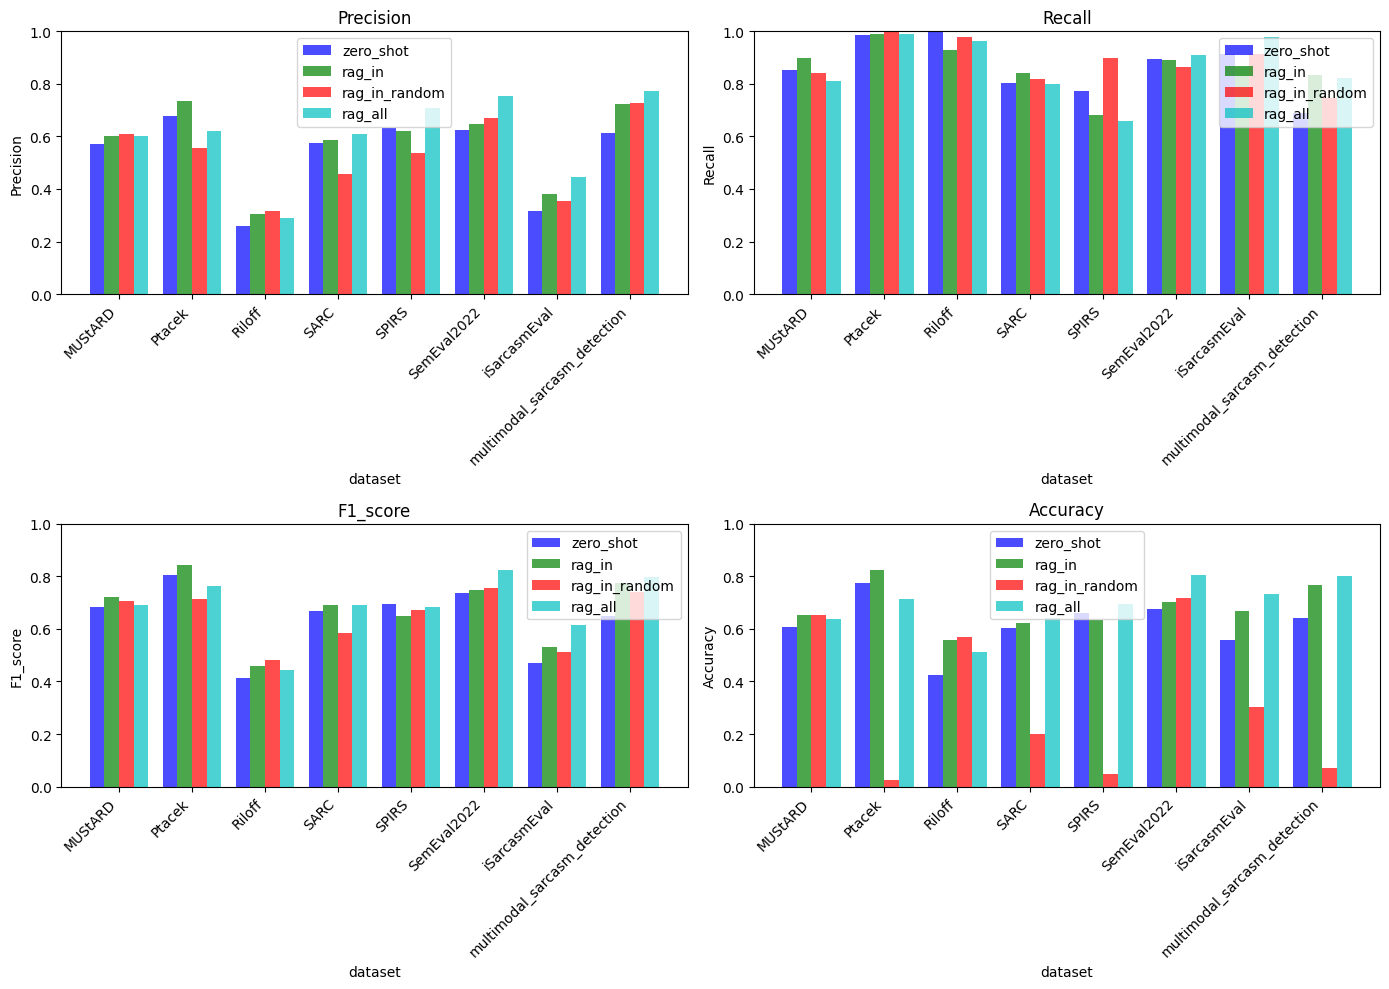

In [3]:
import my_process_data as mpd
file_path = f'./data/all/data_all.csv'
column_names = ["zero_shot", "rag_in","rag_in_random", "rag_all"]
#column_names = ["zero_shot"]

mpd.show_results_from_csv(column_names, file_path)


In [13]:
mpd.get_f1_scores_with_datasets(column_names, file_path)

F1 Scores for zero_shot prompt:
Dataset: MUStARD | F1 Class 0 (f1_neg): 0.48 and 0.48 | F1 Class 1 (f1_pos): 0.68 and 0.68 | Macro F1: 0.58 | Weighted F1: 0.58
-----------------------------
Dataset: Ptacek | F1 Class 0 (f1_neg): 0.73 and 0.73 | F1 Class 1 (f1_pos): 0.80 and 0.80 | Macro F1: 0.77 | Weighted F1: 0.77
-----------------------------
Dataset: Riloff | F1 Class 0 (f1_neg): 0.44 and 0.44 | F1 Class 1 (f1_pos): 0.41 and 0.41 | Macro F1: 0.42 | Weighted F1: 0.43
-----------------------------
Dataset: SARC | F1 Class 0 (f1_neg): 0.50 and 0.50 | F1 Class 1 (f1_pos): 0.67 and 0.67 | Macro F1: 0.59 | Weighted F1: 0.59
-----------------------------
Dataset: SPIRS | F1 Class 0 (f1_neg): 0.62 and 0.62 | F1 Class 1 (f1_pos): 0.69 and 0.69 | Macro F1: 0.66 | Weighted F1: 0.66
-----------------------------
Dataset: SemEval2022 | F1 Class 0 (f1_neg): 0.59 and 0.59 | F1 Class 1 (f1_pos): 0.74 and 0.74 | Macro F1: 0.66 | Weighted F1: 0.66
-----------------------------
Dataset: iSarcasmEval |

In [12]:
import my_process_data as mpd
file_path = './data/all/data_all.csv' 
mpd.analyze_file(file_path)

,Dataset,total_samples,all right,all wrong,both help,only rag_in help,only rag_all help,rag_all interrupted,rag_in interrupted,both interrupted
0,MUStARD,690,315 (45.65%),141 (20.43%),56 (8.12%),30 (4.35%),44 (6.38%),50 (7.25%),26 (3.77%),28 (4.06%)
1,Riloff,1771,625 (35.29%),646 (36.48%),179 (10.11%),132 (7.45%),63 (3.56%),52 (2.94%),41 (2.32%),33 (1.86%)
2,SemEval2022,2133,1220 (57.20%),251 (11.77%),168 (7.88%),46 (2.16%),224 (10.50%),64 (3.00%),109 (5.11%),51 (2.39%)
3,iSarcasmEval,6668,2992 (44.87%),1070 (16.05%),907 (13.60%),355 (5.32%),625 (9.37%),195 (2.92%),362 (5.43%),162 (2.43%)
4,SARC,9900,4221 (42.64%),1946 (19.66%),944 (9.54%),443 (4.47%),595 (6.01%),560 (5.66%),605 (6.11%),586 (5.92%)
5,multimodal_sarcasm_detection,33859,17774 (52.49%),3379 (9.98%),6139 (18.13%),1109 (3.28%),1463 (4.32%),998 (2.95%),1699 (5.02%),1298 (3.83%)
6,SPIRS,30317,13179 (43.47%),3734 (12.32%),3064 (10.11%),1322 (4.36%),2132 (7.03%),1615 (5.33%),2678 (8.83%),2593 (8.55%)
7,Ptacek,68124,42754 (62.76%),6967 (10.23%),3301 (4.85%),3902 (5.73%),1254 (1.84%),6331 (9.29%),1209 (1.77%),2406 (3.53%)


In [4]:
import my_process_data as mpd
to_com = [f'./data/{dataset}/data - copy.csv' for dataset in mpd.datasets]
file_path = './data/all/context/data_all_rag_in_random.csv' 

mpd.combine_csv(to_com, file_path)


In [3]:
import my_rag as mrag
import my_process_data as mpd
for dataset in mpd.datasets:
    file =f'./data/{dataset}/data - copy.csv'
    mrag.add_context_for_csv_random(file)

Processing ./data/SPIRS/data - copy.csv: 100%|██████████| 30317/30317 [01:34<00:00, 321.85it/s]
Processing ./data/multimodal_sarcasm_detection/data - copy.csv: 100%|██████████| 33859/33859 [01:56<00:00, 290.76it/s]
Processing ./data/Ptacek/data - copy.csv: 100%|██████████| 68124/68124 [06:50<00:00, 165.81it/s]


In [5]:
import my_process_data as mpd
file1 = "./data/all/context/small/data_all_rag_in_random.csv"
file2 = "./data/all/context/data_all_rag_in_random.csv"
file3 = "rag_in_random"
mpd.add_column_to_csv_from_other(file1,file2,file3)

Updating rows in file: 100%|██████████| 153462/153462 [08:29<00:00, 301.36it/s]


Updated CSV saved to ./data/all/context/data_all_rag_in_random.csv
